주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [1]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [2]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [4]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('/content/drive/MyDrive/[23-1]_DSL세션/[0209] Clustering 실습 및 과제 자료/marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 데이터 전처리

In [21]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
y = pd.datetime.today().strftime("%Y-%m-%d")
y = pd.to_datetime(y)
########(코드)########(datetime.today().strftime("%Y-%m-%d")) #datetime 타입으로 변환

data.Dt_Customer = pd.to_datetime(data.Dt_Customer)
########(코드)########(data.Dt_Customer) #datetime 타입으로 변환
'''
print(y)
print(type(y))
print(data.Dt_Customer)
'''
data['days'] = y - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype('int')
########(코드)######## #int형으로 변환
data['days'][:5]

<ipython-input-21-e0e71b9335b4>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  y = pd.datetime.today().strftime("%Y-%m-%d")


0    3813
1    3263
2    3462
3    3289
4    3311
Name: days, dtype: int64

In [22]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [25]:
data.iloc[:,20:25]

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
2235,0,0,0,0,0
2236,0,0,0,1,0
2237,0,1,0,0,0
2238,0,0,0,0,0


In [64]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis=1)
########(코드)########(axis=1)
# data['CampaignAttendance'].value_counts()
## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

0    1777
1     325
2      83
3      44
4      11
Name: CampaignAttendance, dtype: int64

In [41]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [42]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [43]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)
########(코드)########(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))
#X_features_scaling

,days,age,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1.529129,0.986443,0.234063,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,...,0.693232,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,2.377952
1,-1.188411,1.236801,-0.234559,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2,-0.205155,0.318822,0.769478,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,...,-0.543978,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
3,-1.059945,-1.266777,-1.017239,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,...,0.280829,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
4,-0.951244,-1.016420,0.240221,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.135772,0.151917,0.356642,-0.104093,1.197646,0.418348,0.066913,0.079693,2.215416,3.919308,...,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2212,-1.652863,1.904422,0.467539,0.241428,0.299208,-0.662463,-0.610954,-0.687574,-0.658233,-0.694260,...,0.693232,-0.281773,-0.282705,-0.280839,3.821732,-0.117148,-0.097812,0.0,0.0,-0.420530
2213,-0.980889,-1.016420,0.188091,1.450751,1.787710,0.544024,0.223001,-0.102990,-0.365998,-0.385402,...,0.280829,-0.281773,3.537258,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530
2214,-0.975948,1.069896,0.675388,-1.417072,0.364441,0.091591,0.209622,0.773887,0.072356,0.328832,...,-0.956381,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,0.0,0.0,-0.420530


###차원 축소

데이터를 차원 축소 해봅시다.

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label)
# X_train_lda
########(코드)########(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

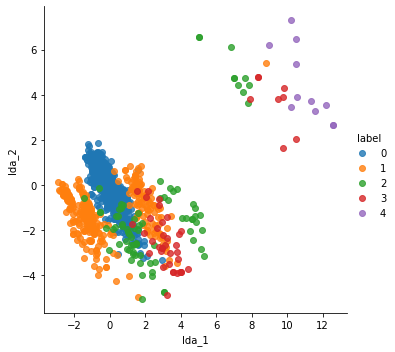

In [54]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1)
########(코드)########((X_train_lda, y_label), axis = 1) #X_train_Ida와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

In [107]:
X_train_lda.loc[:,['lda_1', 'lda_2']]

,lda_1,lda_2
0,1.136967,-1.804852
1,-0.390107,0.562877
2,-0.492550,0.143637
3,-0.353401,0.644298
4,-0.208290,0.529871
...,...,...
2211,0.528615,-1.351187
2212,1.412328,0.439092
2213,-0.421907,-2.493652
2214,-0.353032,-0.057959


###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [51]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

In [55]:
## 필요한 라이브러리를 임포트합니다.

from yellowbrick.cluster import KElbowVisualizer #elbow method

In [56]:
model = KMeans()

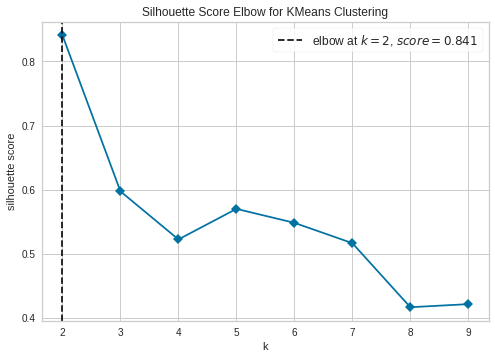

In [58]:
# 실루엣 계수는 '2 <= # of labels <= (# of samples) - 1' 일 때에만 정의됩니다.
elbowvisualizer = KElbowVisualizer(model, k = (2,10), metric = 'silhouette', timings = False) # timings : 돌아가는 시간 안 적어도 된다
elbowvisualizer.fit(X_train_lda.iloc[:,0:2])  
elbowvisualizer.show()

In [65]:
## 클러스터 수는 ########(숫자)########로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 5, random_state = 99)
########(숫자)########

y_km = km.fit_predict(X_features_scaling)
########(코드)########(X_features_scaling)
y_km

array([2, 1, 2, ..., 0, 2, 1], dtype=int32)

In [66]:
X_train_lda['K_means'] = y_km

####시각화

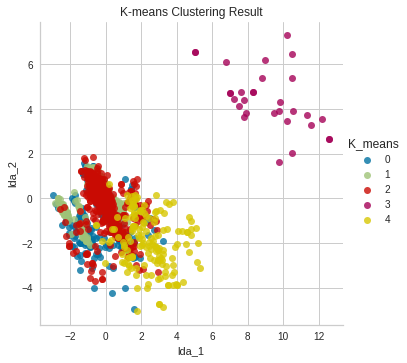

In [67]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [68]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [70]:
## 클러스터 수는 ########(숫자)########로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
########(숫자)########, affinity = 'euclidean', linkage = '########(숫자)########') #와드연결법을 사용합니다.

y_agghc = agghc.fit_predict(X_features_scaling)########(코드)########(X_features_scaling)
y_agghc

array([2, 3, 2, ..., 1, 2, 1])

In [71]:
X_train_lda['hierarchical'] = y_agghc

####시각화

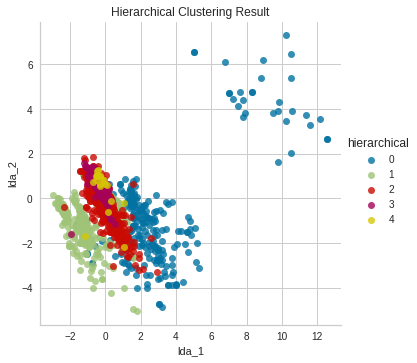

In [72]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [74]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN

In [75]:
import sklearn.utils
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors

In [77]:
nb = NearestNeighbors(n_neighbors = 4).fit(X_features_scaling)
# minPts를 4로 설정했으므로 n_neighbors도 4로 설정

In [78]:
minPts = 4

In [80]:
#kneighbors([X, n_neighbors, return_distance]): Find the K-neighbors of a point.
distances, indices = nb.kneighbors(X_features_scaling)

In [81]:
distances #한 점이 minPts를 만족하는 점들과의 거리

array([[1.19209290e-07, 3.34668520e+00, 3.52977034e+00, 3.53985459e+00],
       [0.00000000e+00, 9.09903423e-01, 9.39336054e-01, 9.58490843e-01],
       [0.00000000e+00, 1.63108673e+00, 1.92351889e+00, 2.01634054e+00],
       ...,
       [0.00000000e+00, 2.85466117e+00, 3.02415529e+00, 3.27335510e+00],
       [0.00000000e+00, 1.42852458e+00, 1.70955064e+00, 1.75579970e+00],
       [0.00000000e+00, 1.14949383e+00, 1.40752549e+00, 1.54215594e+00]])

In [92]:
## eps는 ########(숫자)########, minPts는 ########(숫자)########로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 5.1, min_samples = 4, metric = 'euclidean')
########(숫자)########, min_samples = ########(숫자)########, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit_predict(X_features_scaling)########(코드)########(X_features_scaling)
y_dbscan

array([0, 0, 0, ..., 0, 0, 0])

In [93]:
X_train_lda['dbscan'] = y_dbscan

In [104]:
y_db = dbscan.labels_

In [105]:
# 실제 클러스터 수

cluster_db = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
cluster_db

3

####시각화

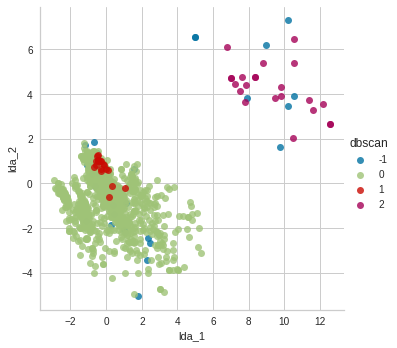

In [103]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

########(의견)########

Hierarchical Clustering이 성능이 제일 높아보이며, DBSCAN이 성능이 제일 낮아보입니다!



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [95]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [97]:
coef_km = metrics.silhouette_score(X_features_scaling, y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.19660255982258726.


Hierarchical Clustering의 실루엣 계수입니다.

In [98]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.17393367899599174.


DBSCAN의 실루엣 계수입니다.

In [106]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling,y_db)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is 0.48526039037233165.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

########(의견)########
*  DBSCAN > K-Means > Hierarchical Clustering




(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

########(의견)########

*   예상과 다르게 DBSCAN이 제일 성능이 높았습니다

(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

########(의견)########

*   마케팅 캠페인에 4회 참여한 고객은 소수에 불과하며, 이들만의 특징을 추출하는 것이 매우 중요할 것으로 보인다.

* 마케팅 캠페인에 많이 참여하게 하는 것이 중요할 수 있기 때문이다.


*   마케팅 캠페인에 4회 참여한 고객과 그 외 의 고객을 따로 분류하여 어떤 다른 특징이 있는지 추가 분석을 진행하는 것이 필요할 것 같다.








